In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code is to show how to optimize the parameter of the time-dependent OU processes based on MLE. This code has been vectorized so that it becomes possible to optimize a set of different sample paths at the same time

In [2]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [3]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

In [4]:
class MLE:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

We simulate two different sample paths from time-dependent OU processes, each of which has the same set of parameters except for $\alpha$ which has a different sign

In [5]:
alpha = torch.tensor([0.633, -0.633]).reshape(2, -1)
beta = torch.tensor([3.59, 3.59]).reshape(2, -1)
r = torch.tensor([1.124, 1.124]).reshape(2, -1)
m0 = torch.tensor([1.79, 1.79]).reshape(2, -1)

In [6]:
true_sde = tOU_vector(t0=0, t1=2, z0=m0, m0=m0, alpha=alpha, beta=beta, sigma=1, r=r, dN=40, D=2, timegrid = 'False')

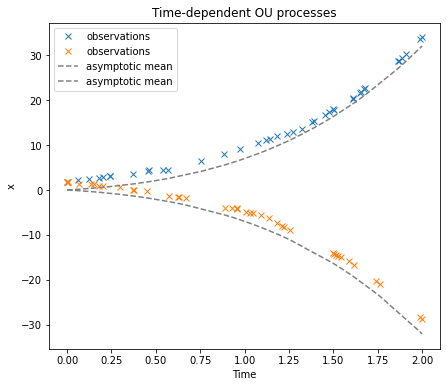

In [7]:
post_mean = lambda x: alpha * (((x + 1) ** beta) - 1) + 0
plt.figure(figsize=(7, 6))
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
plt.plot(true_sde.pts.T, post_mean(true_sde.pts).T, color='grey', linestyle='dashed', label='asymptotic mean')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Time-dependent OU processes")
plt.show()

We make inferences for the parameters of the above sample paths based on gradient descent algorithm. The algorithm is vectorized. 

Note: Gradient descent algorithm is sensitive to initaliziation, in partciular, the sign of $\alpha$. Hence, it is better to initialize $\alpha$ around 0 so that the algorithm finds the right "direction"*

In [8]:
beta_ = torch.tensor([0.5, 0.5], dtype=torch.float64).reshape(2,-1)
alpha_ = torch.tensor([0., 0.], dtype=torch.float64).reshape(2,-1)
r_ = torch.tensor([1., 1.], dtype=torch.float64).reshape(2,-1)

learning_rate = 0.000005
lr = learning_rate
for i in range(50000):
    mle = MLE(true_sde)
    update = mle.compute_score(beta = beta_, alpha=alpha_, m0=m0, r=r_)
    beta_ +=  learning_rate * update['beta']
    alpha_ += learning_rate * update['alpha']
    r__ = r_ + learning_rate * update['r']
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while any(r__ < 0):
        for d in range(r__.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
    r_ = r__
        
    if i % 10000 == 0:
        print("beta = ", beta_.data.numpy(), 'alpha = ', alpha_.data.numpy(), 'r = ', r_.data.numpy())
        print("MLE = ", update['LNN'])

beta =  [[0.5]
 [0.5]] alpha =  [[ 0.00022881]
 [-0.00021781]] r =  [[0.99560515]
 [0.99599554]]
MLE =  [-1038.8098534   -923.78079438]
beta =  [[1.50369063]
 [1.2846785 ]] alpha =  [[ 1.03152825]
 [-0.88793504]] r =  [[0.00132441]
 [0.00119268]]
MLE =  [-270.30228736 -248.34460252]
beta =  [[2.97729198]
 [2.90110925]] alpha =  [[ 1.35243845]
 [-1.40532608]] r =  [[3.12436393e-08]
 [5.91262364e-06]]
MLE =  [25.11622871 37.00762465]
beta =  [[3.19278999]
 [3.46640624]] alpha =  [[ 1.03490655]
 [-0.6905666 ]] r =  [[3.12436393e-08]
 [3.15351111e+00]]
MLE =  [28.07888377 43.46193353]
beta =  [[3.3815747 ]
 [3.54098793]] alpha =  [[ 0.81994027]
 [-0.63691732]] r =  [[3.12436393e-08]
 [3.16987126e+00]]
MLE =  [29.73525525 43.72658297]


Based on MLE estimator, we sample 50 different sample paths from the time-dependent OU. It is clear that these paths encaptulates our observations.

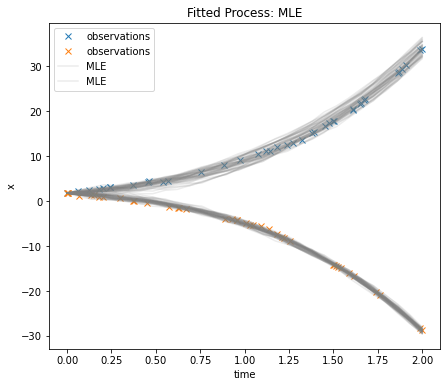

In [9]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(true_sde.pts.T, true_sde.trj.T, 'x', label='observations')
for i in range(50):
    vi = tOU_vector(0, 2, m0, m0, alpha_, beta_, 1., r_, D=2, dN = 30)
    plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi.pts.T, vi.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

Variational inference: KL

In [88]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: -0.5 * (1-(r**2)) * z ** 2 + alpha * beta * (B(s, beta-1) + 1) * z \
                    -0.5 * ((r**2) - 1) * (alpha**2) * (beta**2) * B(s, 2*(beta-1)) \
                    -0.5 * (alpha * (B(s, beta) - 1) + m0 + r * alpha * beta * B(s, beta-1)) \
                    * (2 * z - alpha * (B(s, beta) - 1) - m0 - r * alpha * beta *B(s, beta - 1))
        
        num = func(self.ou.pts, self.ou.trj)

        return torch.trapezoid(abs(num), x=self.ou.pts).reshape(-1, 1)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = torch.tensor(self.ou.t0).repeat(D, 1)
        t1 = torch.tensor(self.ou.t1).repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (r - 1) * 0.5 * (u ** 2) - u * r * alpha * (((s+1) ** beta) - 1) - r * m0 * u - alpha * beta * (s+1) * u
            
        return A(t1, z1) - A(t0, z0) - 0.5 * (r - 1) * (t1 - t0)
    
    def log_prob(self, obs):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z):
            return ss.norm.logpdf(obs, loc=z, scale=.001)
            
        return log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1))


In [118]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = True)
        m0 = Variable(m0, requires_grad = False)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'beta':beta.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Generate observations from Gaussian likelihood**

Noisy Observations from the SDE:

$dX_{t} = -X_{t}dt + \sigma dW_{t}$

In [119]:
true_sde = OU(t0 = 0, t1 = 6., z0 = 10, alpha = 0, beta = 1., sigma = 1., dN=1000)

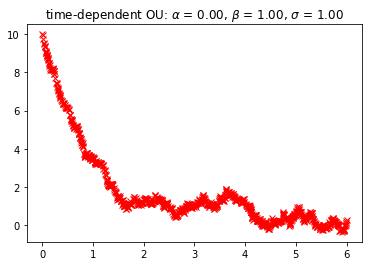

In [120]:
plt.plot(true_sde.pts, true_sde.trj, 'rx')
plt.title(r"time-dependent OU: $\alpha$ = %.2f" % true_sde.alpha + r", $\beta$ = %.2f" % true_sde.beta + r", $\sigma$ = %.2f" % true_sde.sigma)
plt.show()

In [121]:
obs = np.random.normal(loc = true_sde.trj[::100], scale = .001)
obs_time = true_sde.pts[::100]

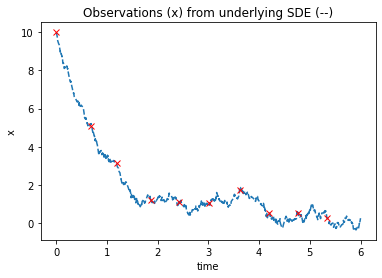

In [122]:
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts, true_sde.trj, '--')
plt.plot(true_sde.pts[::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [123]:
import tqdm as tq

In [125]:
torch.tensor(obs[0]).repeat(5,1)

tensor([[10.0000],
        [10.0000],
        [10.0000],
        [10.0000],
        [10.0000]], dtype=torch.float64)

In [ ]:
D = 50

beta_ = torch.tensor([0.5], dtype=torch.float64).repeat(D,1)
alpha_ = torch.tensor([0.], dtype=torch.float64).repeat(D,1)
r_ = torch.tensor([1.], dtype=torch.float64).repeat(D,1)
m0 = torch.tensor(obs[0]).repeat(D, 1)

N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    
    vi = tOU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
    f_of_X = -1 * (elbo.log_prob(obs[1]) + elbo.KL_ito() + elbo.KL_rest())
    beta_grad += f_of_X * scores['beta']
    alpha_grad += f_of_X * scores['alpha']
    r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r__ = r_ + learning_rate * (r_grad/N).numpy()
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * (r_grad/N).numpy()
        lr *= 0.5
    r_ = r__

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = tOU(t0 = obs_time[0], t1=obs_time[1], z0 = obs[0], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, 'ELBO = ', elbo_estimate)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

**Posterior mean**

In [ ]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [ ]:
# plt.plot(true_sde.pts[:100], true_mean(true_sde.pts)[:100], color='r', alpha=0.3, linestyle='dashed', label="true mean")
plt.plot(true_sde.pts[:100], post_mean(true_sde.pts)[:100], color='black', label="posterior mean")
plt.plot(true_sde.pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
for i in range(50):
    posterior = tOU(t0 = obs_time[0], t1 = obs_time[1], z0 = obs[0], m0 = obs[0], alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

**Trace plot: gradient**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$\beta$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i] for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo)), trace_elbo)
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior moment based on the average of last 30 iterations of beta**

In [ ]:
postmean = post_mean(true_sde.pts[:100])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[:100], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[:100], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
beta_ = 1.
alpha_ = 0.
r_ = 1.
m0 = obs[3]

N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(300)):
    beta_grad = 0.
    alpha_grad = 0.
    r_grad = 0.

    for i in range(N):
        vi = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo = ELBO(vi)
        score = Score(vi)
        
        scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                                    , torch.tensor(m0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))
        f_of_X = -1 * (elbo.log_prob(obs[4]) + elbo.KL_ito() + elbo.KL_rest())
        beta_grad += f_of_X * scores['beta']
        alpha_grad += f_of_X * scores['alpha']
        r_grad += f_of_X * scores['r']
        
    beta_ -= learning_rate * (beta_grad/N).numpy()
    alpha_ -= learning_rate * (alpha_grad/N).numpy()
    r__ = r_ + learning_rate * (r_grad/N).numpy()
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ + lr * (r_grad/N).numpy()
        lr *= 0.5
    r_ = r__

    
    elbo_estimate = 0
    for j in range(N_e):
        vi_ = tOU(t0 = obs_time[3], t1=obs_time[4], z0 = obs[3], m0 = m0, alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
        elbo_ = ELBO(vi_)
        elbo_estimate += -1 * (elbo_.log_prob(obs[4]) + elbo_.KL_ito() + elbo_.KL_rest())
    
    elbo_estimate *= 1/N_e
    
    if k % 100 == 0:
        print("beta = ", beta_, "alpha = ", alpha_, "r = ", r_, 'ELBO = ', elbo_estimate)
    
    trace_pars.append((beta_, alpha_, r_))
    trace_elbo.append(elbo_estimate)
# score.compute_score()

In [ ]:
for i in range(50):
    posterior = tOU(t0 = obs_time[3], t1 = obs_time[4], z0 = obs[3], m0 = obs[3], alpha = alpha_, beta = beta_, sigma = 1, r = r_, dN = 30)
    plt.plot(posterior.pts, posterior.trj, 'b')
    plt.plot(posterior.pts, func(posterior.pts), 'd')
    plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde.pts,true_sde.trj, 'grey', linestyle='dashed')

In [ ]:
post_mean = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [ ]:
alpha_ * ((true_sde.pts[300:400] + 1) ** beta_ - 1) + m0

In [ ]:
toy_sde = tOU(3, 100, m0, m0, alpha_, beta_, 1., r_, dN = 30)
toy_sde_trj, toy_sde_dt = toy_sde.simulate()

In [ ]:
m0

In [ ]:
func = lambda x: alpha_ * (((x + 1) ** beta_) - 1) + m0

In [ ]:
plt.plot(toy_sde.pts, toy_sde_trj, 'rx', label = 'time-dependent OU')
plt.plot(toy_sde.pts, func(toy_sde.pts), linestyle='dashed', color='red', alpha=0.3, label='aymptotic mean')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
postmean = post_mean(true_sde.pts[300:400])

plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde.pts[300:400], postmean, color='black', label="posterior mean")
plt.plot(true_sde.pts,true_sde.trj, 'red', linestyle='dashed', alpha= 0.3)
plt.fill_between(true_sde.pts[300:400], postmean - 0.5/r_, postmean + 0.5/r_, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

2. Complete piece-wise optimization from t=0 to t=10

We use the posterior mean of the previous step as our initial value for next vi

In [ ]:
N = 50
N_e = 50
learning_rate = 0.0000001
lr = learning_rate
z0 = obs[0]
IT = 100

elbo_traces = np.empty((9, IT))
pars_traces = np.empty((3, 9, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    beta_ = np.random.uniform(1, 3)
    alpha_ = 0.
    r_ = np.random.uniform(1, 2)
  
    for i in range(IT):
        beta_grad = 0.
        alpha_grad = 0.
        r_grad = 0.
        
        for k in range(N):
            vi = tOU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_ , beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo = ELBO(vi)
            score = Score(vi)

            scores = score.compute_score(torch.tensor(alpha_, dtype=torch.float64), torch.tensor(beta_, dtype=torch.float64)\
                            , torch.tensor(z0, dtype=torch.float64), torch.tensor(r_, dtype=torch.float64))

            f_of_X = -1 * (elbo.log_prob(obs[t+1]) + elbo.KL_ito() + elbo.KL_rest())
            
            beta_grad += f_of_X * scores['beta']
            alpha_grad += f_of_X * scores['alpha']
            r_grad += f_of_X * scores['r']
            
        beta_ -= learning_rate * (beta_grad/N).numpy()
        alpha_ -= learning_rate * (alpha_grad/N).numpy()
        r__ = r_ + learning_rate * (r_grad/N).numpy()
    
        # It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ + lr * (r_grad/N).numpy()
            lr *= 0.5
        r_ = r__

        
        pars_traces[0, t, i] = alpha_
        pars_traces[1, t, i] = beta_
        pars_traces[2, t, i] = r_
        
        elbo_estimate = 0
        for j in range(N_e):
            vi_ = tOU(t0 = obs_time[t], t1=obs_time[t+1], z0 = z0, m0 = z0, alpha = alpha_, beta = beta_ , sigma = 1., r = r_, dN=30)
            elbo_ = ELBO(vi_)
            elbo_estimate += -1 * (elbo_.log_prob(obs[t+1]) + elbo_.KL_ito() + elbo_.KL_rest())
    
        elbo_estimate *= 1/N_e
        if i % 10 == 0:
            print("alpha = ", alpha_, "beta = ", beta_, "r = ", r_, "elbo = ", elbo_estimate)
        elbo_traces[t, i] = elbo_estimate

    z0 +=  alpha_ * (((obs_time[t+1] + 1) ** np.mean(pars_traces[1, t, -30:])) - 1)
    
# score.compute_score()

Trace plot: ELBO

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :IT])), elbo_traces[t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(pars_traces[0, t, :IT])), pars_traces[0, t, :IT])
    ax.set_xlabel("iteration")
    ax.set_ylabel("beta, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: beta")
plt.show()

In [ ]:
def g_posterior_moment(init, alpha, vi_beta, t0, t1):
    """
        Obtain credible interval
            posterior mean and variance are computed based on the theory (using fitted variational parameter at each interval)
    """
    sigma = 1.
    pts = np.linspace(t0,t1,900)
    dt = pts[1:] - pts[:-1]
    
    mean = [init]
    var = list(map(lambda t: np.sqrt((sigma ** 2 / (2*vi_beta[0])) * (1 - np.exp(-2 * vi_beta[0] * t))), dt[:100]))
    
    k = 0
    for j in range(dt.shape[0]):
        if j % 100 == 0:
            beta = vi_beta[k]
            k += 1
        mean.append(alpha + (mean[j] - alpha)*np.exp(-1 * beta * dt[j]))
        if (j % 100 == 0) and (j > 0):
            func = lambda t: np.sqrt((sigma ** 2 / (2*beta)) * (1 - np.exp(-2 * beta * t)))
            var += list(map(func, dt[j-100:j]))
    return np.array(mean), np.array(var)

In [ ]:
pmean, pvar = g_posterior_moment(obs[0], 0, vi_beta, 0, 6)

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Posterior process")
plt.plot(true_sde.pts, true_sde.trj, alpha=0.3, label='underlying SDE')
plt.plot(true_sde.pts[:900], pmean, 'black', label='posterior mean')
plt.fill_between(true_sde.pts[:900], pmean - pvar, pmean + pvar, alpha=0.5, color='grey')
plt.plot(obs_time, obs, 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()